In [5]:
import pandas as pd
import seaborn as sea
from tqdm import tqdm
from requests import Session
from xml.etree import ElementTree as ET
from requests_cache import CacheMixin
from requests_ratelimiter import LimiterMixin
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from paretoset import paretoset

from common import best_with_map, recommended_with_map

class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(per_second=1)

In [41]:
def chunk_list(lst: list, chunk_size: int):
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def fetch_boardgame_details(boardgame_ids: list[int]):
    chunks = chunk_list(boardgame_ids, 10)
    for chunk in tqdm(chunks, desc='Querying boardgame complexity'):
        id_params = ','.join(str(id) for id in chunk)
        url = f'https://boardgamegeek.com/xmlapi2/thing?id={id_params}&stats=1'
        response = session.get(url)
        response.raise_for_status()        
        root = ET.fromstring(response.text)
        for item in root.findall('item'):
            item_id = int(item.attrib['id'])
            complexity_rating = item.find('statistics/ratings/averageweight').attrib['value']
            complexity_rating = float(complexity_rating)

            item_dict = {
                'id': item_id,
                'complexity': complexity_rating,
                'min_players': int(item.find('minplayers').attrib['value']),
                'max_players': int(item.find('maxplayers').attrib['value']),
                'link': f'https://boardgamegeek.com/boardgame/{item_id}',
                'playing_time': int(item.find('playingtime').attrib['value']),
                'categories': [cat.attrib['value'] for cat in item.findall('link[@type="boardgamecategory"]')],
                'mechanics': [cat.attrib['value'] for cat in item.findall('link[@type="boardgamemechanic"]')],
                'types': [cat.attrib['name'] for cat in item.findall('statistics/ratings/ranks/rank[@type="family"]')],
            }

            for players_summary_results in item.findall('poll-summary/result'):
                item_dict[players_summary_results.attrib['name']] = players_summary_results.attrib['value']

            yield item_dict

df = pd.read_csv('boardgames_ranks.csv')
df = df.query('average > 0 and bayesaverage > 0')
df.set_index('id', inplace=True)

boardgame_details = list(fetch_boardgame_details(df.index[:1000]))
boardgame_details = pd.DataFrame(boardgame_details)
boardgame_details.set_index('id', inplace=True)

df = df.join(boardgame_details, how='inner')
df['bestwith'] = df['bestwith'].map(best_with_map)
df['recommmendedwith'] = df['recommmendedwith'].map(recommended_with_map)

Querying boardgame complexity: 100%|██████████| 100/100 [00:01<00:00, 92.20it/s]


In [42]:
df.sample(10)

,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,...,complexity,min_players,max_players,link,playing_time,categories,mechanics,types,bestwith,recommmendedwith
id,,,,,,,,,,,,,,,,,,,,,
34219,Biblios,2007,468,7.00338,7.19917,17833,0,NaN,NaN,NaN,...,1.6824,2,4,https://boardgamegeek.com/boardgame/34219,30,"[Card Game, Medieval, Religious]","[Auction: Turn Order Until Pass, Auction/Biddi...","[strategygames, familygames]",[3],"[2, 3, 4]"
131357,Coup,2012,666,6.84130,6.98165,47664,0,NaN,NaN,NaN,...,1.4095,2,6,https://boardgamegeek.com/boardgame/131357,15,"[Bluffing, Card Game, Deduction, Party Game, P...","[Hidden Roles, Memory, Player Elimination, Tak...",[partygames],[5],"[3, 4, 5, 6]"
58281,Summoner Wars,2009,742,6.77738,7.23295,6660,0,NaN,35.0,NaN,...,2.3387,2,4,https://boardgamegeek.com/boardgame/58281,60,"[Card Game, Fantasy, Fighting]","[Action Points, Dice Rolling, Grid Movement, H...",[cgs],[2],"[2, 4]"
128671,Spartacus: A Game of Blood and Treachery,2012,465,7.00682,7.46552,9026,0,NaN,NaN,NaN,...,2.7254,3,4,https://boardgamegeek.com/boardgame/128671,180,"[Ancient, Dice, Fighting, Miniatures, Movies /...","[Auction/Bidding, Betting and Bluffing, Briber...",[thematic],[4],"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
192135,Too Many Bones,2017,33,7.87333,8.33813,14107,0,NaN,NaN,NaN,...,3.8561,1,4,https://boardgamegeek.com/boardgame/192135,120,"[Adventure, Dice, Fantasy, Fighting]","[Cooperative Game, Dice Rolling, Die Icon Reso...","[thematic, strategygames]",[2],"[1, 2, 3, 4]"
528,ZÈRTZ,1999,929,6.66287,7.26467,4393,0,23.0,NaN,NaN,...,2.7345,2,2,https://boardgamegeek.com/boardgame/528,60,[Abstract Strategy],"[Grid Movement, Map Reduction, Set Collection]",[abstracts],[2],[2]
172818,Above and Below,2015,373,7.09905,7.36133,16317,0,NaN,NaN,NaN,...,2.5217,2,4,https://boardgamegeek.com/boardgame/172818,90,"[Adventure, City Building, Economic, Explorati...","[Action Points, Dice Rolling, Narrative Choice...",[thematic],[3],"[2, 3, 4]"
238799,Messina 1347,2021,808,6.73588,7.55901,3309,0,NaN,NaN,NaN,...,3.5922,1,4,https://boardgamegeek.com/boardgame/238799,140,"[Economic, Medical, Medieval]","[Grid Movement, Income, Modular Board, Solo / ...",[strategygames],[3],"[1, 2, 3, 4]"
267319,Roam,2019,941,6.65722,7.28935,4086,0,NaN,NaN,NaN,...,1.8333,2,4,https://boardgamegeek.com/boardgame/267319,45,"[Card Game, Fantasy]","[Action Retrieval, Area Majority / Influence, ...",[familygames],[3],"[2, 3, 4]"


In [40]:
df['types'].explode().value_counts().index.to_list()

['strategygames',
 'familygames',
 'thematic',
 'wargames',
 'partygames',
 'abstracts',
 'cgs',
 'childrensgames']

In [35]:
df.to_feather('boardgames_with_details.feather')

In [25]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree


def find_n_closest_points(df, n_neighbors=5):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["bayesaverage", "complexity"]])

    # Split into Pareto and non-Pareto points
    pareto_points = scaled_data[df["is_pareto"]]
    non_pareto_points = scaled_data[~df["is_pareto"]]
    non_pareto_indices = df[~df["is_pareto"]].index

    # Find closest Pareto point for each non-Pareto point
    tree = KDTree(pareto_points)
    distances, _ = tree.query(non_pareto_points, k=1)

    # Return indices of n closest non-Pareto points
    return non_pareto_indices[np.argsort(distances.flatten())[:n_neighbors]]


df = df.dropna(subset=["bayesaverage", "complexity"])
# df['is_pareto'] = paretoset(df[['bayesaverage', 'complexity']], sense=["max", "min"])
df.query("is_pareto")[
    ["name", "bayesaverage", "average", "complexity", "bestwith", "recommmendedwith"]
]

df["almost_pareto"] = False
df.loc[find_n_closest_points(df, n_neighbors=100), "almost_pareto"] = True


<Axes: xlabel='bayesaverage', ylabel='complexity'>

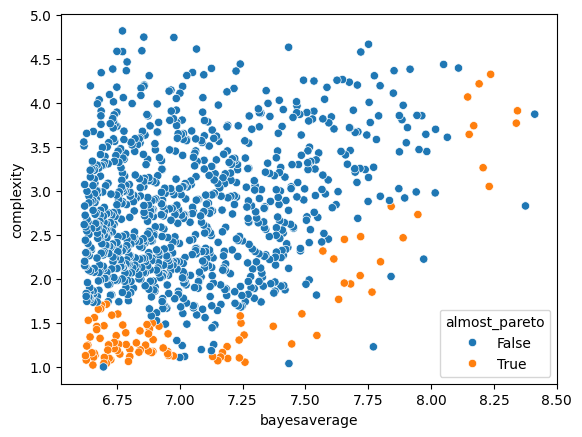

In [26]:
sea.scatterplot(data=df, x='bayesaverage', y='complexity', hue='almost_pareto')